In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
data=pd.read_csv("OnlineRetail.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397481 entries, 0 to 397480
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397481 non-null  object 
 1   StockCode    397481 non-null  object 
 2   Description  396152 non-null  object 
 3   Quantity     397481 non-null  int64  
 4   InvoiceDate  397481 non-null  object 
 5   UnitPrice    397481 non-null  float64
 6   CustomerID   295099 non-null  float64
 7   Country      397481 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 24.3+ MB


In [4]:
data.shape

(397481, 8)

### 2. Clean the data

In [5]:
round(100*(data.isnull().sum())/len(data), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.33
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     25.76
Country         0.00
dtype: float64

In [6]:
data = data.dropna()
data.shape

(295099, 8)

In [7]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


In [8]:
data['amount'] = data['Quantity']*data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom,20.34


### 3. Prepare the data for modelling

In [9]:
Group = data.groupby('CustomerID')['amount'].sum()
Group = Group.reset_index()
Group.head(10)

,CustomerID,amount
0,12346.0,0.00
1,12347.0,2790.86
2,12348.0,1797.24
3,12350.0,334.40
4,12352.0,1233.68
5,12353.0,89.00
6,12354.0,1079.40
7,12355.0,459.40
8,12356.0,2753.08
9,12358.0,484.86


In [10]:
frequency = data.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'frequency']
frequency.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,124
2,12348.0,31
3,12350.0,17
4,12352.0,80


In [11]:
Group = pd.merge(Group, frequency, on='CustomerID', how='inner')
Group.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,2790.86,124
2,12348.0,1797.24,31
3,12350.0,334.40,17
4,12352.0,1233.68,80


In [12]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], 
                                          format='%d/%m/%Y %H:%M')

In [13]:
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,25.50
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,54.08


In [14]:
max_date = max(data['InvoiceDate'])
max_date

Timestamp('2011-10-14 11:15:00')

In [15]:
data['diff'] = max_date - data['InvoiceDate']
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,317 days 02:49:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,317 days 02:49:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,317 days 02:49:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,317 days 02:49:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,317 days 02:49:00
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.30,317 days 02:49:00
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,25.50,317 days 02:49:00
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10,317 days 02:47:00
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10,317 days 02:47:00
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,54.08,317 days 02:41:00


In [16]:
LPurchased = data.groupby('CustomerID')['diff'].min()
LPurchased = LPurchased.reset_index() 
LPurchased.head()

,CustomerID,diff
0,12346.0,269 days 00:58:00
1,12347.0,73 days 02:27:00
2,12348.0,18 days 22:02:00
3,12350.0,253 days 19:14:00
4,12352.0,15 days 20:17:00


In [17]:
Group = pd.merge(Group, LPurchased, on='CustomerID', how='inner')
Group.columns = ['CustomerID', 'amount', 'frequency', 'recency']
Group.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,269 days 00:58:00
1,12347.0,2790.86,124,73 days 02:27:00
2,12348.0,1797.24,31,18 days 22:02:00
3,12350.0,334.40,17,253 days 19:14:00
4,12352.0,1233.68,80,15 days 20:17:00


In [18]:
# number of days only
Group['recency'] = Group['recency'].dt.days
Group.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,269
1,12347.0,2790.86,124,73
2,12348.0,1797.24,31,18
3,12350.0,334.40,17,253
4,12352.0,1233.68,80,15


{'whiskers': [<matplotlib.lines.Line2D at 0x1aef7118400>,
 'caps': [<matplotlib.lines.Line2D at 0x1aef7118ac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1aef7118070>],
 'medians': [<matplotlib.lines.Line2D at 0x1aef71131c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1aef7113520>],
 'means': []}

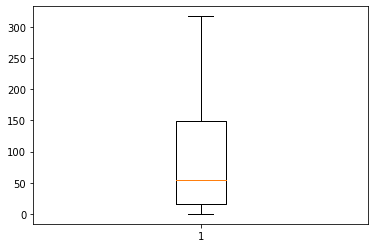

In [19]:
plt.boxplot(Group['recency'])

In [20]:
Q1 = Group.amount.quantile(0.05)
Q3 = Group.amount.quantile(0.95)
IQR = Q3 - Q1
Group = Group[(Group.amount >= Q1 - 1.5*IQR) & (Group.amount <= Q3 + 1.5*IQR)]

In [21]:
Q1 = Group.recency.quantile(0.05)
Q3 = Group.recency.quantile(0.95)
IQR = Q3 - Q1
Group = Group[(Group.recency >= Q1 - 1.5*IQR) & (Group.recency <= Q3 + 1.5*IQR)]

In [22]:
Q1 = Group.frequency.quantile(0.05)
Q3 = Group.frequency.quantile(0.95)

In [23]:
IQR = Q3 - Q1
IQR

245.0

In [24]:
Group = Group[(Group.frequency >= Q1 - 1.5*IQR) & (Group.frequency <= Q3 + 1.5*IQR)]
Group

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,269
1,12347.0,2790.86,124,73
2,12348.0,1797.24,31,18
3,12350.0,334.40,17,253
4,12352.0,1233.68,80,15
...,...,...,...,...
3814,18280.0,180.60,10,221
3815,18281.0,80.82,7,124
3816,18282.0,98.76,8,65
3817,18283.0,1120.67,447,38


In [25]:
rfm_df = Group[['amount', 'frequency', 'recency']]

scaler = StandardScaler()

rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(3758, 3)

In [26]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.714628,-0.759877,1.938544
1,1.052928,0.688205,-0.215385
2,0.423631,-0.415661,-0.819804
3,-0.502840,-0.581834,1.762714
4,0.066708,0.165946,-0.852772


### 4. Modelling

In [27]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [28]:
kmeans.labels_

array([0, 2, 1, ..., 1, 2, 1])

#### Finding the Optimal Number of Clusters

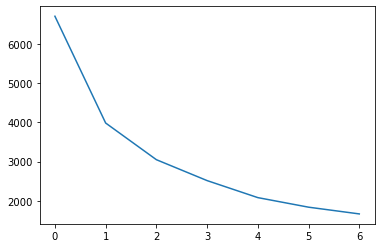

In [29]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)

plt.plot(ssd)

#### Silhouette Analysis
silhouette score=p−qmax(p,q)

p

is the mean distance to the points in the nearest cluster that the data point is not a part of

q

is the mean intra-cluster distance to all the points in its own cluster.

    The value of the silhouette score range lies between -1 to 1.

    A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

    A score closer to -1 indicates that the data point is not similar to the data points in its cluster.


In [30]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

For n_clusters=2, the silhouette score is 0.5353222533945915
For n_clusters=3, the silhouette score is 0.4712389027703927
For n_clusters=4, the silhouette score is 0.4595999470892445
For n_clusters=5, the silhouette score is 0.44536097868576346
For n_clusters=6, the silhouette score is 0.4045336200756215
For n_clusters=7, the silhouette score is 0.39717536622415667
For n_clusters=8, the silhouette score is 0.3881925023822511


In [31]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [32]:
kmeans.labels_

array([1, 0, 0, ..., 0, 2, 0])

In [33]:
Group['cluster_id'] = kmeans.labels_
Group.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,269,1
1,12347.0,2790.86,124,73,0
2,12348.0,1797.24,31,18,0
3,12350.0,334.40,17,253,1
4,12352.0,1233.68,80,15,0


<AxesSubplot:xlabel='cluster_id', ylabel='amount'>

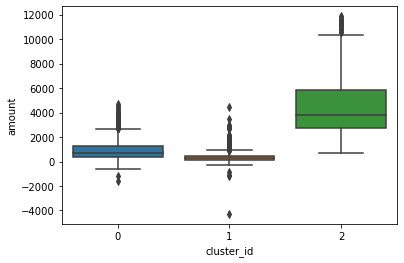

In [34]:
# plot
sns.boxplot(x='cluster_id', y='amount', data=Group)

### Hierarchical Clustering

In [35]:
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.714628,-0.759877,1.938544
1,1.052928,0.688205,-0.215385
2,0.423631,-0.415661,-0.819804
3,-0.502840,-0.581834,1.762714
4,0.066708,0.165946,-0.852772


In [36]:
Group.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,269,1
1,12347.0,2790.86,124,73,0
2,12348.0,1797.24,31,18,0
3,12350.0,334.40,17,253,1
4,12352.0,1233.68,80,15,0


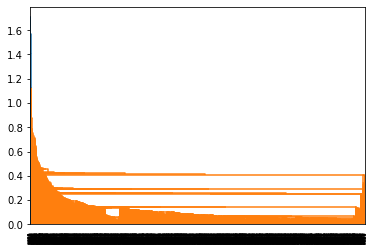

In [37]:
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

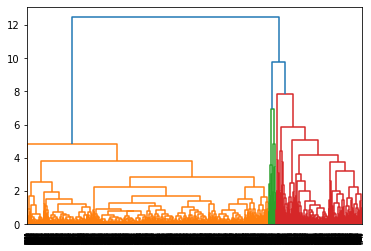

In [38]:
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [39]:
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, ..., 0, 2, 1])

In [40]:
Group['cluster_labels'] = cluster_labels
Group.head()

,CustomerID,amount,frequency,recency,cluster_id,cluster_labels
0,12346.0,0.00,2,269,1,0
1,12347.0,2790.86,124,73,0,1
2,12348.0,1797.24,31,18,0,1
3,12350.0,334.40,17,253,1,0
4,12352.0,1233.68,80,15,0,1


<AxesSubplot:xlabel='cluster_labels', ylabel='recency'>

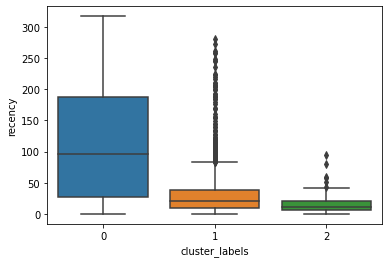

In [41]:
sns.boxplot(x='cluster_labels', y='recency', data=Group)

<AxesSubplot:xlabel='cluster_labels', ylabel='frequency'>

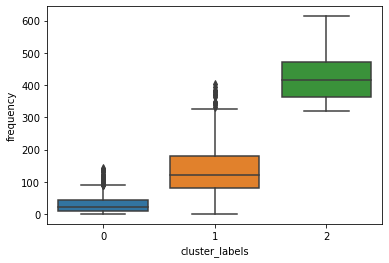

In [42]:
sns.boxplot(x='cluster_labels', y='frequency', data=Group)

<AxesSubplot:xlabel='cluster_labels', ylabel='amount'>

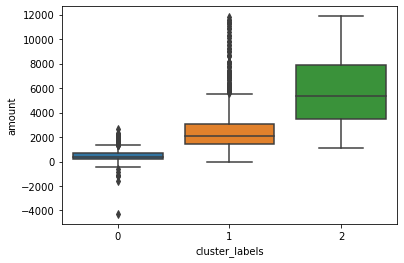

In [43]:
# plots
sns.boxplot(x='cluster_labels', y='amount', data=Group)